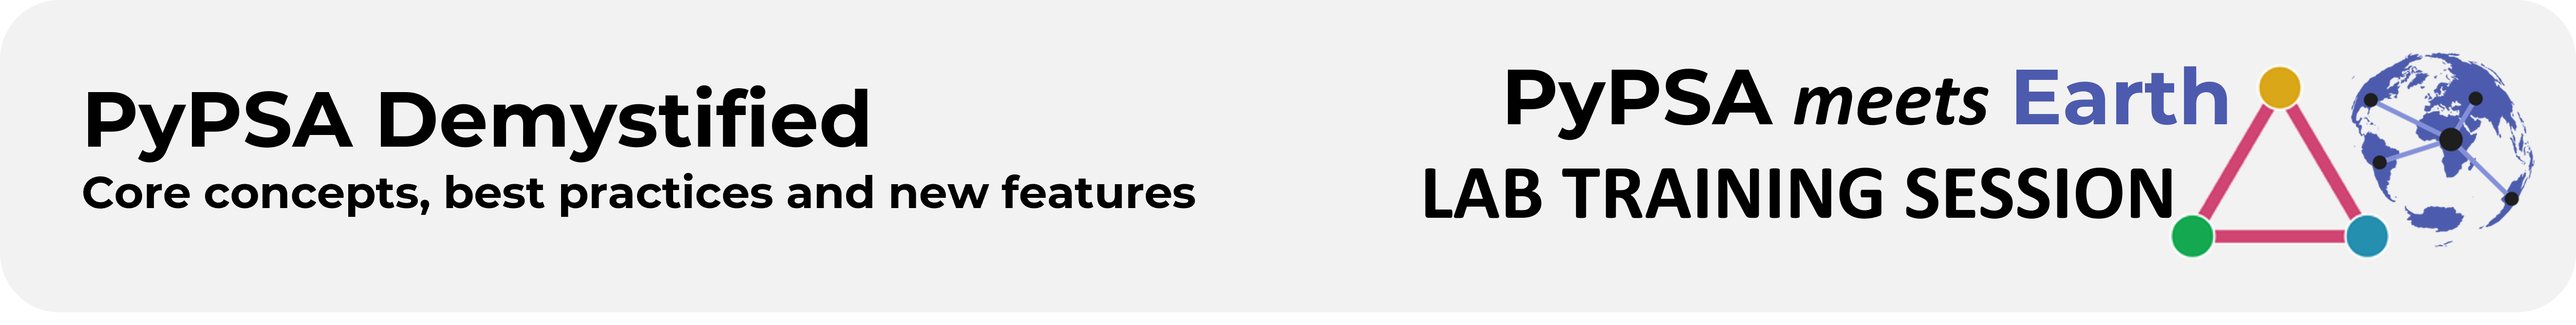

**Session Instructor:**  

**Priyesh Gosai**
Director: Energy Solutions  
PAS-SA

📧 [pgosai@pas-sa.co.za](mailto:pgosai@pas-sa.co.za)  
🌐 [www.pas-sa.co.za](https://www.pas-sa.co.za)  
🔗 [LinkedIn](https://www.linkedinetwork.com/in/gosaip/)  
💻 [GitHub](https://github.com/PriyeshGosai)


# **Part 2: Developing a model using Excel**



# Install packages for Google Colab



In [ ]:
#@title Connect to Google Drive {display-mode:"form"}
CONNECT_TO_DRIVE = True #@param {type:"boolean"}

from google.colab import drive
import os

if CONNECT_TO_DRIVE:
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the desired working directory path
    working_dir = '/content/drive/MyDrive/hello-pypsa'

    # Create the directory if it doesn't exist
    if not os.path.exists(working_dir):
        os.makedirs(working_dir)
        print(f"Directory '{working_dir}' created.")
    else:
        print(f"Directory '{working_dir}' already exists.")

    # Change the current working directory
    os.chdir(working_dir)

    print(f"Current working directory: {os.getcwd()}")
else:
    print("Not connecting to Google Drive.")

In [ ]:
import os

#@title Install Packages {display-mode:"form"}
INSTALL_PACKAGES = True #@param {type:"boolean"}

# Check if packages have already been installed in this session to prevent re-installation
if INSTALL_PACKAGES and not os.environ.get('PYPSA_PACKAGES_INSTALLED'):
  !pip install pypsa pypsa[excel] folium mapclassify cartopy
  os.environ['PYPSA_PACKAGES_INSTALLED'] = 'true'
elif not INSTALL_PACKAGES:
  print("Skipping package installation.")
else:
  print("PyPSA packages are already installed for this session.")

In [ ]:
#@title Download the file for this notebook {display-mode:"form"}
DOWNLOAD_FILE = True #@param {type:"boolean"}

if DOWNLOAD_FILE:
    !wget https://github.com/PriyeshGosai/pypsa-meets-earth-lab-2025/blob/main/network_ZA.xlsx -O network_ZA.xlsx
else:
    print("Skipping file download.")

In [ ]:
# #@title Connect to Google Drive {display-mode:"form"}
# CONNECT_TO_DRIVE = True #@param {type:"boolean"}

# from google.colab import drive
# import os

# if CONNECT_TO_DRIVE:
#     # Mount Google Drive
#     drive.mount('/content/drive')

#     # Define the desired working directory path
#     working_dir = '/content/drive/MyDrive/hello-pypsa'

#     # Create the directory if it doesn't exist
#     if not os.path.exists(working_dir):
#         os.makedirs(working_dir)
#         print(f"Directory '{working_dir}' created.")
#     else:
#         print(f"Directory '{working_dir}' already exists.")

#     # Change the current working directory
#     os.chdir(working_dir)

#     print(f"Current working directory: {os.getcwd()}")
# else:
#     print("Not connecting to Google Drive.")

In [ ]:
# !pip install pypsa pypsa[excel] folium mapclassify
# !pip install git+https://github.com/PriyeshGosai/pypsa_network_viewer.git

In [ ]:
# !wget "https://docs.google.com/spreadsheets/d/1s_3NPMUlv8XU0PwKFw1it7rdvuY8D--g/export?format=xlsx&id=1s_3NPMUlv8XU0PwKFw1it7rdvuY8D--g" -O network_ZA.xlsx

# Exercise 3

## Example outline

Import a network from an excel file

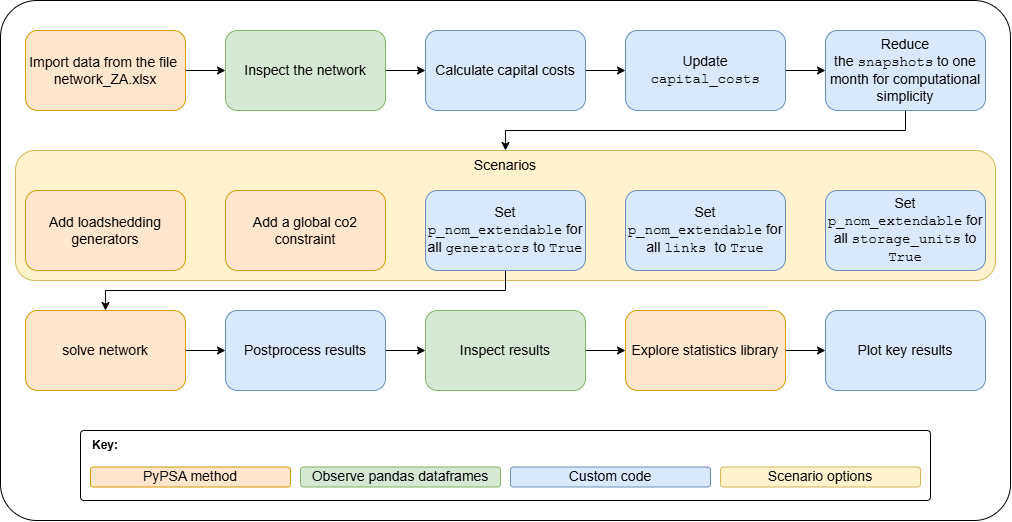

## Import network

In [ ]:
import pypsa
import pandas as pd
pd.set_option('plotting.backend', 'plotly')
pypsa.options.api.new_components_api = True


n_ZA = pypsa.Network('network_ZA.xlsx')


## Inspect network

In [ ]:
# Create a Series with MultiIndex (bus, generator_type) containing capacity
gen_capacity_by_type = n_ZA.generators.static.groupby(['bus', 'carrier'])['p_nom'].sum()

# Reshape to have bus as index and carriers as columns
gen_capacity_pivot = n_ZA.generators.static.groupby(['bus', 'carrier'])['p_nom'].sum().unstack(fill_value=0)

# Convert to Series with MultiIndex for bus_split_circle
gen_capacity_multiindex = gen_capacity_pivot.stack()

n_ZA.plot.explore(
    bus_size=gen_capacity_multiindex,
    bus_size_factor=1,  # Adjust scale
    bus_split_circle=True,  # Split into pie-like circles
    bus_color=gen_capacity_multiindex,
    line_color='rosybrown',
    link_color='cyan'
)

In [ ]:
# Create a Series with MultiIndex (bus, generator_type) containing capacity
gen_capacity_by_type = n_ZA.generators.static.groupby(['bus', 'carrier'])['p_nom'].sum()

# Reshape to have bus as index and carriers as columns
gen_capacity_pivot = n_ZA.generators.static.groupby(['bus', 'carrier'])['p_nom'].sum().unstack(fill_value=0)

# Convert to Series with MultiIndex for bus_split_circle
gen_capacity_multiindex = gen_capacity_pivot.stack()

n_ZA.plot.explore(
    bus_size=gen_capacity_multiindex,
    bus_size_factor=1,  # Adjust scale
    bus_split_circle=True,  # Split into pie-like circles
    bus_color=gen_capacity_multiindex,
    line_color='rosybrown',
    link_color='cyan'
)

In [ ]:
n_ZA.buses

In [ ]:
n_ZA.generators

In [ ]:
n_ZA.lines

In [ ]:
n_ZA.links

In [ ]:
n_ZA.loads

In [ ]:
n_ZA.storage_units

## Calculate capital costs

In [ ]:
lcoe_ZAR_MW_dict = {'coal':140e6,'gas':10e6,'solar':20e6,'wind':27e6,'battery':26e6}
discount_rate_dict = {'coal':0.08,'gas':0.08,'solar':0.12,'wind':0.12,'battery':0.12}
investment_period = {'coal':40,'gas':20,'solar':15,'wind':15,'battery':12}
annuity_ZAR_MW_dict ,annuity_factor_dict  ={} , {}

for key in lcoe_ZAR_MW_dict:
    annuity_factor_dict[key] = pypsa.common.annuity(discount_rate_dict[key],investment_period[key])
    annuity_ZAR_MW_dict[key] = lcoe_ZAR_MW_dict[key]* annuity_factor_dict[key]





In [ ]:
import numpy as np
import pandas as pd

capital_cost_USD_mile_MW = 1502
rate_USD_ZAR = 18
conversion_mile_km = 1.6
capital_cost_ZAR_km_MW = capital_cost_USD_mile_MW*rate_USD_ZAR/conversion_mile_km 

# Get the bus connections
links = n_ZA.links.static[['bus0', 'bus1']].copy()

# Get the bus coordinates
buses = n_ZA.buses.static[['x', 'y']]

# Create a dictionary for quick lookup of bus coordinates
bus_coords = buses.to_dict('index')

# Calculate line lengths
line_lengths = []

for idx, row in links.iterrows():
    bus0 = row['bus0']
    bus1 = row['bus1']
    
    # Get coordinates
    x0, y0 = bus_coords[bus0]['x'], bus_coords[bus0]['y']
    x1, y1 = bus_coords[bus1]['x'], bus_coords[bus1]['y']
    
    # Calculate Euclidean distance in degrees
    length_degrees = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    
    # Convert to kilometers
    length_km = length_degrees * 111.32 # Average Earth radius: 6371 km therefore 1 degree at equator ≈ 111.32 km
    line_lengths.append(length_km)

# Add lengths to the links dataframe
links.loc[:, 'length'] = line_lengths

links['links_cost'] = links['length'] * capital_cost_ZAR_km_MW





In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax = plt.subplots(figsize=(12, 5))

# Get keys and values
keys = list(annuity_ZAR_MW_dict.keys())
annuity_values = list(annuity_ZAR_MW_dict.values())

# Create bar chart
bars = ax.bar(keys, annuity_values, color='steelblue', edgecolor='black', linewidth=1.2)

# Remove grid lines
ax.grid(False)

# Add annotations on top of each bar
for i, (key, bar) in enumerate(zip(keys, bars)):
    height = bar.get_height()
    
    # Prepare annotation text
    lcoe_value = lcoe_ZAR_MW_dict[key] * 1e-6  # Scale by 1e-6
    discount_rate_value = discount_rate_dict[key] * 1e2  # Scale by 1e2
    investment_years = investment_period[key]
    annuity_factor = annuity_factor_dict[key]
    
    annotation_text = (
        f"LCOE: {lcoe_value:.2f} M ZAR/MW\n"
        f"Discount Rate: {discount_rate_value:.1f}%\n"
        f"Investment Period: {investment_years} Years\n"
        f"Annuity Factor : {annuity_factor:0.3f}"
    )
    
    # Place text above the bar
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        annotation_text,
        ha='center',
        va='bottom',
        fontsize=9,
        # bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='gray', alpha=0.8)
    )

# Labels and title
ax.set_ylabel('Annuity (ZAR/MW)', fontsize=11)
ax.set_xlabel('Options', fontsize=11)
ax.set_title('Capital cost annuity', fontsize=13, fontweight='bold')
ax.set_ylim(0,max(annuity_ZAR_MW_dict.values())*1.2)
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

## Update the model

In [ ]:
n_ZA.generators.static['p_nom_min'] = n_ZA.generators.static['p_nom']
n_ZA.links.static['p_nom_min'] = n_ZA.links.static['p_nom']
n_ZA.storage_units.static['p_nom_min'] = n_ZA.storage_units.static['p_nom']

n_ZA.storage_units.static.loc[n_ZA.storage_units.static['carrier'] == 'battery', 'capital_cost'] = annuity_ZAR_MW_dict['battery']
n_ZA.links.static.loc[:,'capital_cost'] = links['links_cost']
n_ZA.generators.static['capital_cost'] = n_ZA.generators.static['carrier'].map(annuity_ZAR_MW_dict)

## Simplify the model

In [ ]:
month = 4

n_ZA.snapshots = n_ZA.snapshots[(n_ZA.snapshots.month == month)]
n_months = n_ZA.snapshots.to_period('M').nunique()/12


n_ZA.links.static['capital_cost'] = n_ZA.links.static['capital_cost'] / 12
n_ZA.generators.static['capital_cost'] = n_ZA.generators.static['capital_cost'] / 12
n_ZA.storage_units.static['capital_cost'] = n_ZA.storage_units.static['capital_cost'] / 12

## Scenarios

Consider four scenarios.

* **Scenario 1**

    Determine the dispatch for the plant if no new generation is added.

    In this case you will need to add loadshedding generators as there is insufficient capacity. 

* **Scenario 2**

    Determine the optimal nominal power if we optimise for generation capacity. 


* **Scenario 3**

    Determine the optimal nominal power if we co-optimise generation and transmission capacity. 

* **Scenario 4**

    Determine the optimal nominal power if we co-optimise generation, transmission and storage capacity. 

    This simulation will take approximately 6 minutes to solve. 

_Note:_
_For all scenarios, consider including a carbon constraint_



**Code for exercises**


This is a method in PyPSA that adds loadshedding busses in the case that there is insufficient capacity to meet demand. Only use this in Scenario 1.

```
n_ZA.optimize.add_load_shedding(buses = n_ZA.buses.static.index,marginal_cost = 10000)
```

Adjust the CO2 Global Constraint

```
co2_limit = 6e6*12 # tonnes/year 
n_ZA.add("GlobalConstraint","CO2_limit",carrier_attribute="co2_emissions",sense="<=",constant=co2_limit*n_months)
```

We can use these pandas commands to set the p_nom_extendable status for generators, links, lines (not used in this example) or storage_units. 

```
n_ZA.generators.static['p_nom_extendable'] = False

n_ZA.links.static['p_nom_extendable'] = False

n_ZA.storage_units.static.loc[n_ZA.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = False
```

For the case of generators, you may want to only make generators associated with specific carriers extendable. 

```
n_ZA.generators.static.loc[(n_ZA.generators.static['carrier'] == 'solar') | 
                            (n_ZA.generators.static['carrier'] == 'wind') |
                            (n_ZA.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True    
```

In [ ]:
# n_ZA.optimize.add_load_shedding(buses = n_ZA.buses.static.index,marginal_cost = 10000)

co2_limit = 6e6*12 # tonnes/year 
n_ZA.add("GlobalConstraint","CO2_limit",carrier_attribute="co2_emissions",sense="<=",constant=co2_limit*n_months)

n_ZA.generators.static['p_nom_extendable'] = True
n_ZA.generators.static.loc[(n_ZA.generators.static['carrier'] == 'solar') | 
                            (n_ZA.generators.static['carrier'] == 'wind') |
                            (n_ZA.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True    

n_ZA.links.static['p_nom_extendable'] = False

n_ZA.storage_units.static.loc[n_ZA.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = True



## Solve network

In [ ]:
n_ZA.optimize()

## Postprocess results

In [ ]:
df_p_nom_gen_opt = n_ZA.generators.static['p_nom_opt']
df_p_nom_gen_opt = df_p_nom_gen_opt.drop(df_p_nom_gen_opt[df_p_nom_gen_opt.index.str.contains('load shedding')].index)
df_p_nom_tx_opt = n_ZA.links.static['p_nom_opt']
df_p_nom_bess_opt = n_ZA.storage_units.static['p_nom_opt']

Calculate total emissions

In [ ]:
total_emissions = 0

for gen in n_ZA.generators.static.index:
    carrier = n_ZA.generators.static.loc[gen, 'carrier']
    efficiency = n_ZA.generators.static.loc[gen, 'efficiency']
    co2_emissions_factor = n_ZA.carriers.static.loc[carrier, 'co2_emissions']
    
    # Get the dispatch time series
    dispatch = n_ZA.generators.dynamic.p[gen]
    
    # Calculate emissions: (dispatch / efficiency) * emission_factor
    gen_emissions = (dispatch / efficiency) * co2_emissions_factor
    
    total_emissions += gen_emissions.sum()

print(f"Total CO2 Emissions: {total_emissions:2f} tCO2")

## Observe model outputs

## Explore the statistics library

In [ ]:
n_ZA.statistics.energy_balance.iplot(kind = 'area')

In [ ]:
n_ZA.statistics.capacity_factor.iplot()


## Plot key results

In [ ]:
# Extract original p_nom values
df_p_nom_gen = n_ZA.generators.static['p_nom']
df_p_nom_gen = df_p_nom_gen.drop(df_p_nom_gen[df_p_nom_gen.index.str.contains('load shedding')].index)

df_p_nom_tx = n_ZA.links.static['p_nom']
df_p_nom_bess = n_ZA.storage_units.static['p_nom']

# Switch to matplotlib backend
pd.set_option('plotting.backend', 'matplotlib')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Plot 1: Generators
x = range(len(df_p_nom_gen))
width = 0.35
axes[0].bar([i - width/2 for i in x], df_p_nom_gen, width, label='Original p_nom', alpha=0.8)
axes[0].bar([i + width/2 for i in x], df_p_nom_gen_opt, width, label='Optimized p_nom_opt', alpha=0.8)
axes[0].set_title('Generator Power Comparison')
axes[0].set_ylabel('Power (MW)')
axes[0].set_xlabel('Generator')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_p_nom_gen.index, rotation=45, ha='right', fontsize=8)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Transmission
x = range(len(df_p_nom_tx))
width = 0.35
axes[1].bar([i - width/2 for i in x], df_p_nom_tx, width, label='Original p_nom', alpha=0.8)
axes[1].bar([i + width/2 for i in x], df_p_nom_tx_opt, width, label='Optimized p_nom_opt', alpha=0.8)
axes[1].set_title('Transmission Power Comparison')
axes[1].set_ylabel('Power (MW)')
axes[1].set_xlabel('Link')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_p_nom_tx.index, rotation=45, ha='right', fontsize=8)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Battery Storage
x = range(len(df_p_nom_bess))
width = 0.35
axes[2].bar([i - width/2 for i in x], df_p_nom_bess, width, label='Original p_nom', alpha=0.8)
axes[2].bar([i + width/2 for i in x], df_p_nom_bess_opt, width, label='Optimized p_nom_opt', alpha=0.8)
axes[2].set_title('Battery Storage Power Comparison')
axes[2].set_ylabel('Power (MW)')
axes[2].set_xlabel('Storage Unit')
axes[2].set_xticks(x)
axes[2].set_xticklabels(df_p_nom_bess.index, rotation=45, ha='right', fontsize=8)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Switch back to plotly if needed
pd.set_option('plotting.backend', 'plotly')